In [97]:
import argparse
from PIL import Image
import torch
import torch.nn as nn
import glob
import os
from torch.utils.data import DataLoader,Dataset
import pandas as pd
import torchvision.transforms as transforms
import numpy as np

In [98]:
# reference from https://discuss.pytorch.org/t/solved-reverse-gradients-in-backward-pass/3589/4
from torch.autograd import Function
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg()

def grad_reverse(x):
    return GradReverse.apply(x)

In [99]:
class DATA(Dataset):
    def __init__(self, img_path,transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])) :
        self.img_path = img_path
        self.transform = transform
        self.filepaths = []
        self.filenames = []
        fns = glob.glob(os.path.join(img_path+'/*.png'))
        for i in fns:
            self.filepaths.append(i)
            self.filenames.append(os.path.basename(i))
        self.len = len(self.filepaths)
    
    def __getitem__(self, index) :
        fp = self.filepaths[index]
        img = Image.open(fp).convert('RGB')
        fn = self.filenames[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, fn, 

    def __len__(self):
        return self.len

In [100]:
class DATA(Dataset):
    def __init__(self, img_path, label=True,transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])) :
        self.img_path = img_path
        self.transform = transform
        self.label = label
        state = os.path.basename(img_path)

        self.labels = pd.read_csv(os.path.join(os.path.dirname(img_path),'{}.csv'.format(state)),index_col='image_name')
        
        self.filepaths = []
        fns = glob.glob(os.path.join(img_path+'/*.png'))
        for i in fns:
            self.filepaths.append(i)
        self.len = len(self.filepaths)
    
    def __getitem__(self, index) :
        fn = self.filepaths[index]
        img = Image.open(fn).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img,self.labels['label'][os.path.basename(fn)]
    
    def __len__(self):
        return self.len

In [101]:
class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 28, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(28, 28 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(28 * 2, 28 * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(28 * 4, 28 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(28 * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.realfake = nn.Sequential(
            nn.Conv2d(28 * 8, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.cls = nn.Sequential(
            nn.Conv2d(28 * 8, 10, 2, 1, 0, bias=False),
            nn.Softmax()
        )
        

    def forward(self, input):
        input = self.main(input)
        rev_input = grad_reverse(input)
        dt = self.realfake(rev_input)
        cls = self.cls(input)
        return dt ,cls, input

In [103]:
def output(model,test_dataloader, csv_path):
    labels = []
    fns = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for data,fn in test_dataloader:
        data = data.to(device)
        output = model(data)[1].view(-1,10)
        pred = output.max(1, keepdim=False)[1].tolist()
        labels += pred
        fns += [i for i in fn]
    pd.DataFrame(
        {
            "image_id":fns,
            "label":labels
        }
    ).to_csv(csv_path,index = False)

In [138]:
img_path = 'hw2_data/digits/mnistm/test'
traget_name = 'mnistm'
csv_path = 'test.csv'
source_dataloader = DataLoader(DATA(img_path = 'hw2_data/digits/svhn/train'),batch_size=128) 
target_dataloader =  DataLoader(DATA(img_path = 'hw2_data/digits/mnistm/train'),batch_size=128)
from sklearn import manifold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('mnistm.pth', map_location=device).to(device)
tsne_src = []
tsne_tar = []
label_src = []
label_tar = []
domain_src = []
domain_tar = []

for (source,target) in zip(source_dataloader,target_dataloader):
    src_img, src_label = source
    tar_img, tar_label = target
    src_img, tar_img = src_img.to(device), tar_img.to(device)

    src_fea = model(src_img)[2]
    tar_fea = model(tar_img)[2]
    for i in range(len(src_fea)):
        tsne_src.append(src_fea[i].cpu().detach().numpy())
        label_src.append(src_label[i])
        domain_src.append(0)
        

    for i in range(len(tar_fea)):
        tsne_tar.append(tar_fea[i].cpu().detach().numpy())
        label_tar.append(tar_label[i])
        domain_tar.append(1)

tsne_src, tsne_tar = np.array(tsne_src).reshape((len(tsne_src),-1)), np.array(tsne_tar).reshape((len(tsne_tar),-1))
tsne_src = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(tsne_src)
tsne_tar = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(tsne_tar)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60032 samples in 0.042s...
[t-SNE] Computed neighbors for 60032 samples in 115.727s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60032
[t-SNE] Computed conditional probabilities for sample 2000 / 60032
[t-SNE] Computed conditional probabilities for sample 3000 / 60032
[t-SNE] Computed conditional probabilities for sample 4000 / 60032
[t-SNE] Computed conditional probabilities for sample 5000 / 60032
[t-SNE] Computed conditional probabilities for sample 6000 / 60032
[t-SNE] Computed conditional probabilities for sample 7000 / 60032
[t-SNE] Computed conditional probabilities for sample 8000 / 60032
[t-SNE] Computed conditional probabilities for sample 9000 / 60032
[t-SNE] Computed conditional probabilities for sample 10000 / 60032
[t-SNE] Computed conditional probabilities for sample 11000 / 60032
[t-SNE] Computed conditional probabilities for sample 12000 / 60032
[t-SNE] Computed conditional probabilities for s

In [139]:
label_src_ = [i.tolist() for i in label_src]
label_tar_ = [i.tolist() for i in label_tar]
# domain_src_ = [i.tolist() for i in domain_src]
# domain_tar_ = [i.tolist() for i in domain_tar]
df_src = pd.DataFrame(
    {
        'x':tsne_src[:,0],
        'y':tsne_src[:,1],
        'label':label_src_,
        'domain':domain_src
    }
)
df_tar = pd.DataFrame(
    {
        'x':tsne_tar[:,0],
        'y':tsne_tar[:,1],
        'label':label_tar_,
        'domain':domain_tar
    }
)

In [140]:
df = pd.concat([df_src,df_tar])
len(df)

120032

<AxesSubplot:xlabel='x', ylabel='y'>

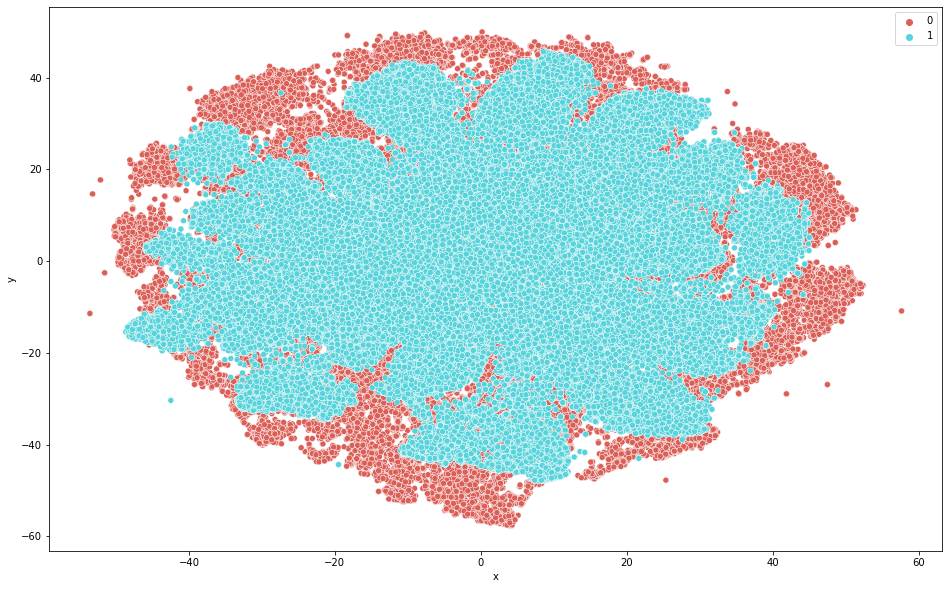

In [141]:

import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd


plt.figure(figsize=(16,10))
sns.scatterplot(
    data = df,
    x='x', y='y',
    hue=df.domain.tolist(),
    palette=sns.color_palette("hls", 2),
)



<AxesSubplot:xlabel='x', ylabel='y'>

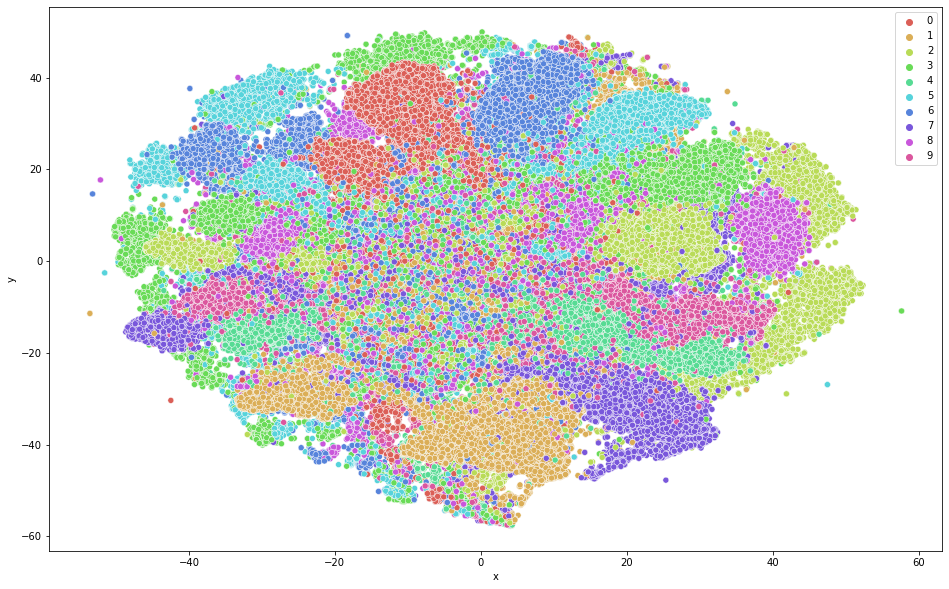

In [142]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    data = df,
    x='x', y='y',
    hue=df.label.tolist(),
    palette=sns.color_palette("hls", 10),
)


In [ ]:
# parser =  argparse.ArgumentParser(description='Use to predict image for HW1_p1')
# parser.add_argument( '--img_path', type=str, default='', help='path to testing images in the target domain' )
# parser.add_argument( '--traget_name', type=str, default='', help='a string that indicates the name of the target domain,which will be either mnistm, usps or svhn.')
# parser.add_argument( '--csv_path', type=str, default='', help='path to your output prediction file')
# args = parser.parse_args()

# img_path = args.img_path
# traget_name = args.traget_name
# csv_path = args.csv_path

img_path = 'hw2_data/digits/mnistm/test'
traget_name = 'mnistm'
csv_path = 'test.csv'

# img_path = 'HW1/p1_data/v_6'
# csv_path = 'out/pred.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
test_dataset = DATA(img_path)
print(len(test_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=128)
model = torch.load('{}.pth'.format(traget_name), map_location=device).to(device)
output(model, test_dataloader,csv_path)

cuda
10000


KeyboardInterrupt: 